In [1]:
from foobah.gcode import GCODE
from foobah.utils import preview_png
from foobah.methods import line_threshold
from foobah import constants
from foobah.constants import XMAX, XMIN, YMAX, YMIN

import PIL
import PIL.Image
import PIL.ImageFilter

import math
import numpy as np

import random
from random import uniform
from scipy.spatial import Voronoi, KDTree

from collections import defaultdict
from operator import itemgetter
from itertools import pairwise

from IPython.display import display

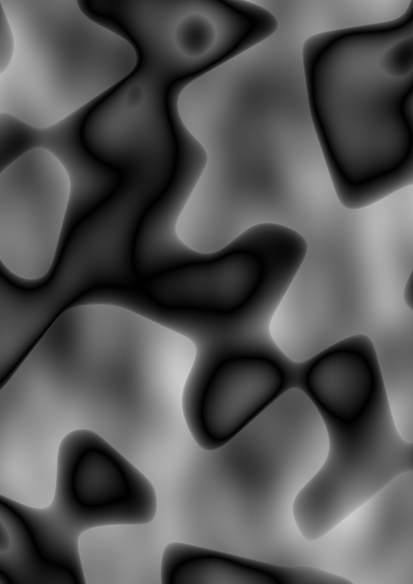

In [2]:
basename = "random_voronoi"

scale = 6
# image_name = "images/moonface.png"
# image_name = "images/einstein.jpg"
# image_name = "images/david-bowie.jpg"
# image_name  = "images/scary_penguin.webp"
# image_name = "images/portrait_1.jpg"
# image_name = "images/dafoe.jpg"
image_name = "images/simplex_noise_difference_clouds.png"

image = PIL.Image.open(image_name)

image = image.resize((int(image.width / scale), int(image.height / scale)), PIL.Image.ANTIALIAS)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)
# image = image.filter(PIL.ImageFilter.CONTOUR)
# image = image.filter(PIL.ImageFilter.DETAIL)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)

# image = image.rotate(-90, expand=True)

image = image.convert("RGB")

width = image.width
height = image.height

display(image)

In [3]:
point_cloud = []

pixel_step = 8

for x in range(0, image.width, pixel_step):
    for y in range(0, image.height, pixel_step):
        dx = uniform(-pixel_step / 2, pixel_step / 2)
        dy = uniform(-pixel_step / 2, pixel_step / 2)
        
        try:
            r, g, b = image.getpixel((x + dx, y + dy))
        except IndexError:
            continue
            
        intensity = ((255 - r) + (255 - g) + (255 - b)) / (255 * 3.0)
#         intensity = 1.0 - intensity
        
        if pow(intensity, 2.0) > uniform(0.2, 1):
            point_cloud.append((x + dx, y + dy))
            
print(len(point_cloud))

1388


In [4]:
min_dist = 3
print(len(point_cloud))

for _ in range(10):
    kd_tree = KDTree(point_cloud)
    close_points = kd_tree.query_pairs(min_dist)

    d = defaultdict(int)
    for p1, p2 in close_points:
        d[p1] += 1
        d[p2] += 1

    d_ = sorted(d.items(), key=itemgetter(1), reverse=True)

    point_cloud = [x for index, x in enumerate(point_cloud) if index not in d or uniform(0, 1) > 0.25]
    print(len(point_cloud))

1388
1365
1339
1334
1331
1330
1329
1328
1328
1328
1327


In [5]:
point_cloud = [x for x in point_cloud if uniform(0, 1) > 0.25]
print(len(point_cloud)) 

995


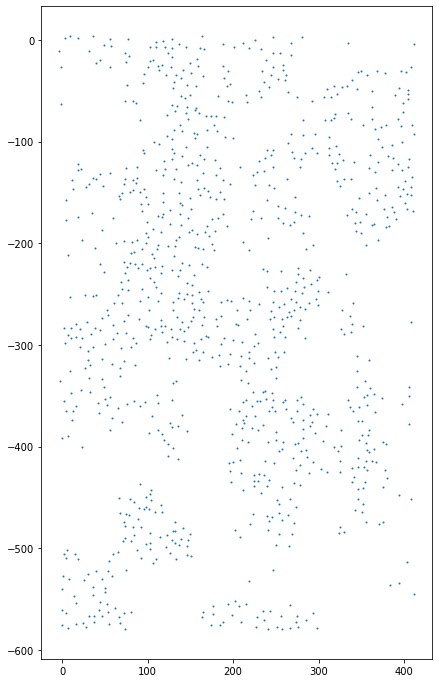

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 12))
plt.scatter(
    [x[0] for x in point_cloud], 
    [-x[1] for x in point_cloud],
    s=1,
)

In [7]:
def get_adjacent_edge(edges, vertex, eps=1e-4):
    for k, (v1, v2) in enumerate(edges):

        if dist(v1, vertex) < eps:
            return k, (v1, v2)
        
        if dist(v2, vertex) < eps:
            return k, (v2, v1)
        
    return None, None


def dist(a, b):
    if isinstance(a, (list, tuple)):
        a = np.array(a)
        
    if isinstance(b, (list, tuple)):
        b = np.array(b)
        
    return np.linalg.norm(a-b)

In [8]:
voronoi = Voronoi(point_cloud, furthest_site=False)
edges = []

for region in voronoi.regions:
    if -1 in region:
        continue
        
    polygon = list(voronoi.vertices[region])
    if len(polygon) == 0:
        continue
        
    polygon.append(polygon[0])
    zero = (0, 0)
    
    for p1, p2 in pairwise(polygon):
        p1 = tuple(p1)
        p2 = tuple(p2)
        if dist(0, p1) < dist(0, p2):
            edges.append((p1, p2))
        else:
            edges.append((p2, p1))


print(len(edges))
edges = list(set(edges))
print(len(edges))

5822
2949


In [9]:
def plot_line(gcode, edges):
    v1, v2 =edges.pop(0)
    
    gcode.pen_up()
    move_to(gcode, *v1)
    
    gcode.pen_down()
    
    move_to(gcode, *v2)
    
    while True:
        k, v = get_adjacent_edge(edges, v2)
        if not k:
            break
        
        edges.pop(k)
        _,  v2 = v
        
        move_to(gcode, *v2)
        
    
    gcode.pen_up()

In [10]:
def move_to(gcode, x, y, feedrate=1500):
    gcode.move_to(
        ((x) / image.width) * (XMAX - XMIN) + XMIN,
        ((y) / image.height) * (YMAX - YMIN) + YMIN,
        feedrate=feedrate,
    )
    
    
gcode = GCODE(basename, feedrate=1500)
gcode.draw_boundaries()
gcode.pen_up()
gcode.move_to_mid_point()

# for region in voronoi.regions:
#     if -1 in region:
#         continue
        
#     polygon = voronoi.vertices[region]
#     if len(polygon) == 0:
#         continue
    
#     gcode.pen_up()
#     move_to(gcode, *polygon[0])
#     gcode.pen_down()
    
#     for p in polygon[1:]:
#         move_to(gcode, *p)
        
#     move_to(gcode, *polygon[0])
    
#     gcode.pen_up()

    
while len(edges) > 0:
    print(len(edges))
    plot_line(gcode, edges)
    
    
gcode.pen_up()
gcode.move_to_starting_position()
gcode.flush()

2949
2928
2905
2891
2858
2842
2823
2800
2776
2739
2715
2686
2660
2632
2615
2608
2603
2578
2570
2547
2512
2502
2496
2478
2472
2451
2445
2443
2434
2423
2414
2407
2400
2385
2371
2332
2318
2315
2301
2299
2290
2286
2259
2250
2236
2234
2214
2191
2188
2186
2175
2151
2142
2112
2105
2103
2092
2077
2075
2067
2065
2059
2040
2014
2012
1985
1979
1971
1968
1957
1950
1943
1932
1930
1909
1904
1897
1889
1886
1878
1873
1862
1859
1855
1840
1837
1829
1826
1821
1812
1811
1808
1798
1795
1772
1771
1765
1755
1745
1741
1737
1735
1724
1716
1713
1711
1709
1703
1698
1695
1691
1681
1676
1667
1658
1651
1639
1634
1632
1630
1623
1618
1616
1612
1610
1608
1605
1603
1597
1591
1585
1579
1577
1567
1565
1560
1558
1555
1554
1550
1547
1540
1530
1526
1521
1514
1510
1502
1500
1495
1491
1485
1482
1478
1470
1468
1461
1458
1455
1453
1447
1443
1437
1435
1432
1429
1418
1417
1410
1407
1402
1396
1394
1392
1384
1383
1375
1374
1369
1363
1361
1359
1355
1353
1349
1348
1340
1336
1332
1325
1321
1317
1313
1310
1306
1304
1301
1299
1296
1291


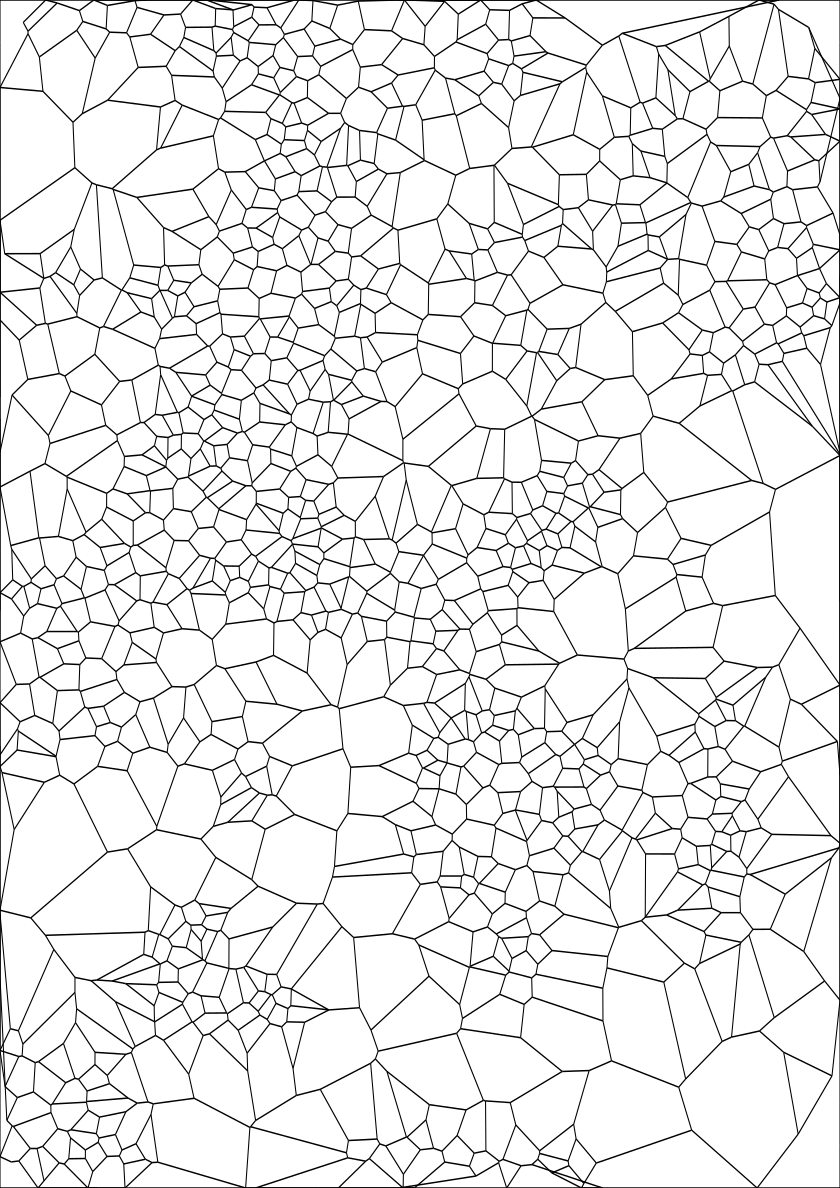

In [12]:
preview_png(basename, scale=4)